In [1]:
from transformers import SwinForImageClassification, SwinConfig
import torch.nn as nn
import torch.optim as optim
import torch

model = SwinForImageClassification.from_pretrained('microsoft/swin-tiny-patch4-window7-224')

# Adjust the classifier head for 120 classes (dog breeds)
NUM_CLASSES=120
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES)

# Define device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

In [2]:
import os

import cv2

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.layers import InputLayer,Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization,Resizing, Rescaling

from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast, RandomZoom, GaussianNoise

from tensorflow.keras.regularizers import L2

from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
import tarfile
import numpy as np

import numpy as np

from PIL import Image

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-29 15:11:56--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: 'images.tar'

images.tar          100%[===================>] 756.82M  6.54MB/s    in 1m 43s  

2024-10-29 15:13:39 (7.36 MB/s) - 'images.tar' saved [793579520/793579520]

--2024-10-29 15:13:40--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: 'annotation.tar'

annotation.tar      100%[===================>]  20.84M  6.19MB/s    in 3.4s    

2024-10-29 15:13:43 (6.19 MB/s) - 'annotat

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import LabelEncoder

class DogDataset(Dataset):
    def __init__(self, image_dir, img_height, img_width, transform=None):
        self.image_dir = image_dir
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load and preprocess images and labels
        self._load_images_and_labels()

        # Encode labels (convert string labels to numerical values)
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)  # Encode the labels

    def _load_images_and_labels(self):
        for breed in os.listdir(self.image_dir):
            breed_folder = os.path.join(self.image_dir, breed)
            if os.path.isdir(breed_folder):
                for img_name in os.listdir(breed_folder):
                    img_path = os.path.join(breed_folder, img_name)
                    
                    if os.path.isfile(img_path):
                        img = Image.open(img_path)
                        
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        
                        img = img.resize((self.img_height, self.img_width))
                        self.images.append(img)
                        self.labels.append(breed)  # Add the breed name as the label
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        # Convert label to tensor (already encoded as integer)
        label = torch.tensor(label, dtype=torch.long)  # Now label is already an integer
        return img, label

   
def extract_tarfile(tar_file, dest_path):
    with tarfile.open(tar_file, 'r') as tar:
        tar.extractall(path=dest_path)
        
# Set image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
NUM_CLASSES = 120  # Number of dog breeds

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_HEIGHT),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])




In [5]:
image_tarfile = '/kaggle/working/images.tar'
extracted_image_dir = '/kaggle/working/images'
extract_tarfile(image_tarfile, extracted_image_dir)


In [6]:
extracted_image_dir="/kaggle/working/images/Images"
dataset = DogDataset(extracted_image_dir, IMG_HEIGHT, IMG_WIDTH, transform=train_transform)


In [7]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(dataset.labels)

X_train, X_temp, y_train, y_temp = train_test_split(dataset.images, labels_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = DogDataset(extracted_image_dir, IMG_HEIGHT, IMG_WIDTH, transform=train_transform)
val_dataset = DogDataset(extracted_image_dir, IMG_HEIGHT, IMG_WIDTH, transform=val_test_transform)
test_dataset = DogDataset(extracted_image_dir, IMG_HEIGHT, IMG_WIDTH, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


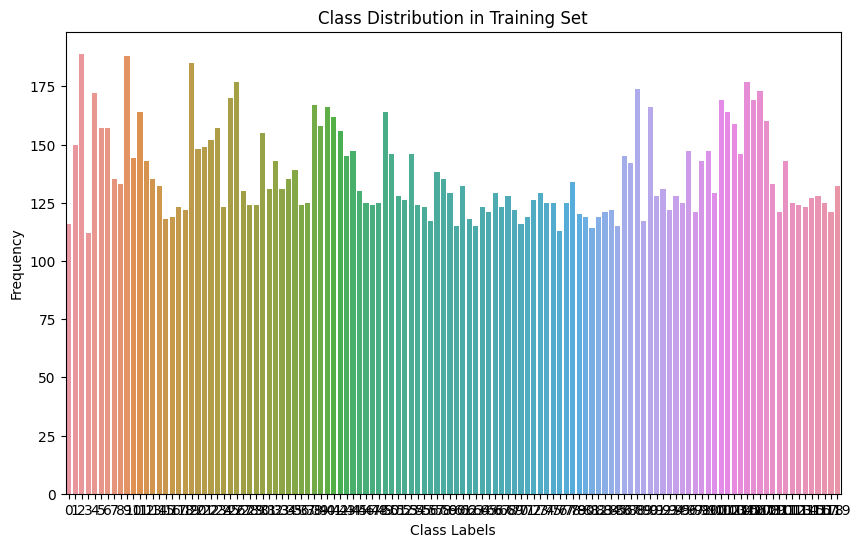

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts)
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Set")
plt.show()


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


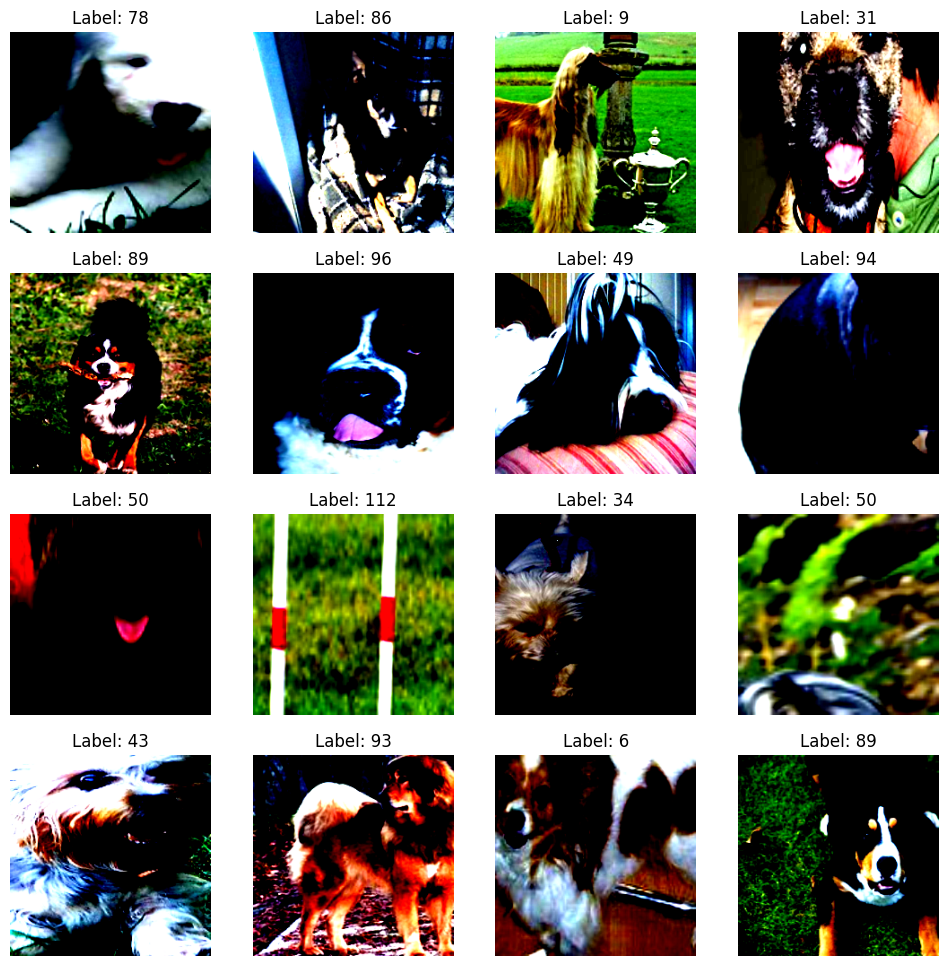

In [17]:
import torchvision.transforms as T
from PIL import Image

# Define a function to plot a grid of images
def show_images(data_loader, num_images=16):
    images, labels = next(iter(data_loader))  # Get a batch of images and labels
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        img = images[i].permute(1, 2, 0)  # Rearrange dimensions for plotting (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.title(f'Label: {labels[i].item()}')
        plt.axis("off")
    plt.show()

# Visualize images from the training set
show_images(train_loader)


In [8]:
y_val

array([84, 10, 72, ..., 81,  9, 65])

In [8]:
import tqdm as notebook_tqdm

In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=4):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%')
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        print(f'Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100 * val_correct/val_total}%')
        
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=5)


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Loss: 1.45463527873251, Accuracy: 63.517978620019434%
Validation Loss: 0.5129468953233323, Validation Accuracy: 83.70748299319727%
Epoch 2, Loss: 0.913461101999194, Accuracy: 74.24198250728863%
Validation Loss: 0.38231789379674214, Validation Accuracy: 87.87172011661808%
Epoch 3, Loss: 0.7943477424683038, Accuracy: 77.55102040816327%
Validation Loss: 0.3178620691868905, Validation Accuracy: 89.47521865889213%
Epoch 4, Loss: 0.7334310651889869, Accuracy: 79.02818270165209%
Validation Loss: 0.292923261648386, Validation Accuracy: 90.21865889212827%
Epoch 5, Loss: 0.6522095282995923, Accuracy: 81.58892128279884%
Validation Loss: 0.2157467496321972, Validation Accuracy: 92.72108843537416%


In [8]:
weight_decay = 0.01  
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=4):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%')
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        print(f'Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100 * val_correct/val_total}%')
        
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=15)


Epoch 1, Loss: 1.9610237523635723, Accuracy: 47.50728862973761%
Validation Loss: 1.555881227788903, Validation Accuracy: 55.98153547133139%
Epoch 2, Loss: 2.0801479772010945, Accuracy: 45.22837706511176%
Validation Loss: 2.013427692691084, Validation Accuracy: 44.43148688046647%
Epoch 3, Loss: 2.1738101623443344, Accuracy: 43.226433430515065%
Validation Loss: 1.7657853800410068, Validation Accuracy: 50.35957240038873%
Epoch 4, Loss: 2.2392993887759145, Accuracy: 41.156462585034014%
Validation Loss: 1.7864238269488264, Validation Accuracy: 49.64528668610301%
Epoch 5, Loss: 2.3063121062258016, Accuracy: 39.64042759961127%
Validation Loss: 1.7864209123372292, Validation Accuracy: 50.38872691933916%
Epoch 6, Loss: 2.365178760534488, Accuracy: 38.352769679300295%
Validation Loss: 1.9624937020057107, Validation Accuracy: 46.564625850340136%
Epoch 7, Loss: 2.392208840350927, Accuracy: 38.21671525753158%
Validation Loss: 1.8988203236960477, Validation Accuracy: 47.1622934888241%
Epoch 8, Loss:

# class weight


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import torch

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Move to the same device as model


In [10]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [15]:
class_weights

tensor([1.1828, 0.9147, 0.7259, 1.2250, 0.7977, 0.8739, 0.8739, 1.0163, 1.0316,
        0.7298, 0.9528, 0.8366, 0.9594, 1.0163, 1.0394, 1.1627, 1.1529, 1.1154,
        1.1246, 0.7416, 0.9270, 0.9208, 0.9026, 0.8739, 1.1154, 0.8071, 0.7751,
        1.0554, 1.1065, 1.1065, 0.8852, 1.0473, 0.9594, 1.0473, 1.0163, 0.9871,
        1.1065, 1.0976, 0.8216, 0.8684, 0.8265, 0.8469, 0.8795, 0.9462, 0.9333,
        1.0554, 1.0976, 1.1065, 1.0976, 0.8366, 0.9397, 1.0719, 1.0889, 0.9397,
        1.1065, 1.1154, 1.1726, 0.9942, 1.0163, 1.0636, 1.1930, 1.0394, 1.1627,
        1.1930, 1.1154, 1.1339, 1.0636, 1.1154, 1.0719, 1.1246, 1.1828, 1.1529,
        1.0889, 1.0636, 1.0976, 1.0976, 1.2142, 1.0976, 1.0239, 1.1433, 1.1529,
        1.2035, 1.1529, 1.1339, 1.1246, 1.1930, 0.9462, 0.9662, 0.7885, 1.1726,
        0.8265, 1.0719, 1.0473, 1.1246, 1.0719, 1.0976, 0.9333, 1.1339, 0.9594,
        0.9333, 1.0636, 0.8118, 0.8366, 0.8629, 0.9397, 0.7751, 0.8118, 0.7931,
        0.8575, 1.0316, 1.1339, 0.9594, 

In [14]:
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=15)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Loss: 2.5537637388854293, Accuracy: 35.0242954324587%
Validation Loss: 2.1009069002748277, Validation Accuracy: 43.74635568513119%
Epoch 2, Loss: 2.547213817049998, Accuracy: 35.01457725947522%
Validation Loss: 2.0960960855580266, Validation Accuracy: 44.31972789115646%
Epoch 3, Loss: 2.556139933951893, Accuracy: 34.946550048590865%
Validation Loss: 2.233217700760557, Validation Accuracy: 40.80660835762877%
Epoch 4, Loss: 2.56744986791048, Accuracy: 34.902818270165206%
Validation Loss: 2.221230567242048, Validation Accuracy: 41.17103984450923%
Epoch 5, Loss: 2.5739062865328344, Accuracy: 34.95626822157434%
Validation Loss: 2.2491198222829687, Validation Accuracy: 40.61710398445092%
Epoch 6, Loss: 2.600996667739027, Accuracy: 34.67930029154519%
Validation Loss: 2.187454132097108, Validation Accuracy: 42.12827988338192%
Epoch 7, Loss: 2.609579122214584, Accuracy: 34.203109815354715%
Validation Loss: 2.17709011320742, Validation Accuracy: 42.6773566569485%
Epoch 8, Loss: 2.618869

# SGD

In [9]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=4):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct/total}%')
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        print(f'Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {100 * val_correct/val_total}%')
        
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=weight_decay)
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=30)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Loss: 4.80474066808357, Accuracy: 0.86977648202138%
Validation Loss: 4.780023803622086, Validation Accuracy: 1.1758989310009718%
Epoch 2, Loss: 4.762221991645624, Accuracy: 1.5840621963070942%
Validation Loss: 4.736529911526982, Validation Accuracy: 2.006802721088435%
Epoch 3, Loss: 4.725430772911688, Accuracy: 2.619047619047619%
Validation Loss: 4.691457963137893, Validation Accuracy: 3.2896015549076774%
Epoch 4, Loss: 4.6829352956380905, Accuracy: 3.58600583090379%
Validation Loss: 4.642404566640439, Validation Accuracy: 4.99514091350826%
Epoch 5, Loss: 4.637644510091461, Accuracy: 5.451895043731779%
Validation Loss: 4.586883676718481, Validation Accuracy: 7.196307094266278%
Epoch 6, Loss: 4.582275327688419, Accuracy: 7.706511175898931%
Validation Loss: 4.521855905929708, Validation Accuracy: 9.723032069970845%
Epoch 7, Loss: 4.518660614209145, Accuracy: 10.10204081632653%
Validation Loss: 4.44263019546959, Validation Accuracy: 12.682215743440233%
Epoch 8, Loss: 4.4383590895

In [16]:
label_encoder = dataset.label_encoder

# Get the list of class names
class_names = label_encoder.classes_

# Create a mapping of label numbers to class names
label_mapping = {i: class_name for i, class_name in enumerate(class_names)}

print("Label Mapping:", label_mapping)

Label Mapping: {0: 'n02085620-Chihuahua', 1: 'n02085782-Japanese_spaniel', 2: 'n02085936-Maltese_dog', 3: 'n02086079-Pekinese', 4: 'n02086240-Shih-Tzu', 5: 'n02086646-Blenheim_spaniel', 6: 'n02086910-papillon', 7: 'n02087046-toy_terrier', 8: 'n02087394-Rhodesian_ridgeback', 9: 'n02088094-Afghan_hound', 10: 'n02088238-basset', 11: 'n02088364-beagle', 12: 'n02088466-bloodhound', 13: 'n02088632-bluetick', 14: 'n02089078-black-and-tan_coonhound', 15: 'n02089867-Walker_hound', 16: 'n02089973-English_foxhound', 17: 'n02090379-redbone', 18: 'n02090622-borzoi', 19: 'n02090721-Irish_wolfhound', 20: 'n02091032-Italian_greyhound', 21: 'n02091134-whippet', 22: 'n02091244-Ibizan_hound', 23: 'n02091467-Norwegian_elkhound', 24: 'n02091635-otterhound', 25: 'n02091831-Saluki', 26: 'n02092002-Scottish_deerhound', 27: 'n02092339-Weimaraner', 28: 'n02093256-Staffordshire_bullterrier', 29: 'n02093428-American_Staffordshire_terrier', 30: 'n02093647-Bedlington_terrier', 31: 'n02093754-Border_terrier', 32: 'n

Predicted Class: 1


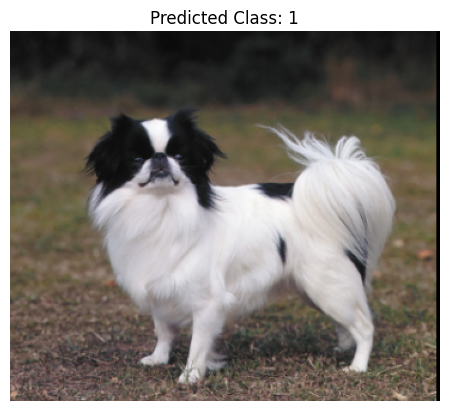

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def predict_image(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(device)  

    model.eval()
    with torch.no_grad():
        output = model(input_image).logits
        _, predicted = output.max(1)
        prediction = predicted.item()
        print(f'Predicted Class: {prediction}')

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction}')
    plt.show()

image_path = '/kaggle/input/japanese-spaniel/Screenshot 2024-10-29 215202.png'
predict_image(model, image_path, device)


Predicted Class: 57


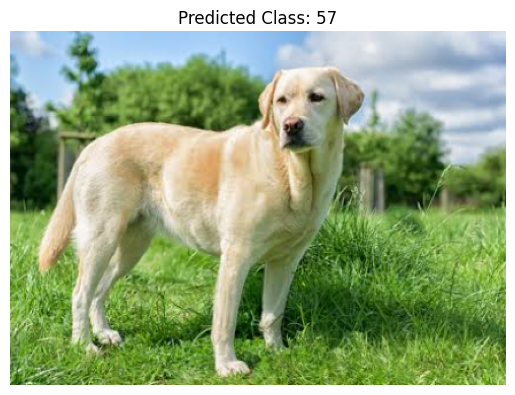

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def predict_image(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(device)  

    model.eval()
    with torch.no_grad():
        output = model(input_image).logits
        _, predicted = output.max(1)
        prediction = predicted.item()
        print(f'Predicted Class: {prediction}')

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction}')
    plt.show()

image_path = '/kaggle/input/labrador/Screenshot 2024-10-29 215829.png'
predict_image(model, image_path, device)


Predicted Class: 24


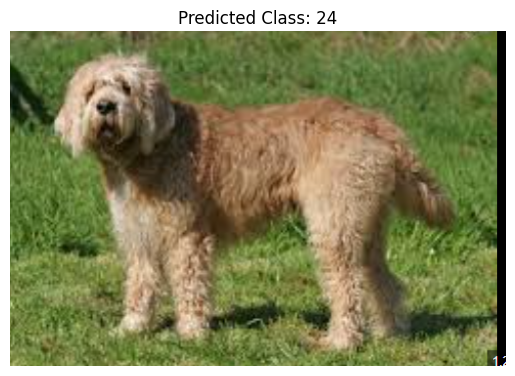

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def predict_image(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(device)  

    model.eval()
    with torch.no_grad():
        output = model(input_image).logits
        _, predicted = output.max(1)
        prediction = predicted.item()
        print(f'Predicted Class: {prediction}')

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Class: {prediction}')
    plt.show()

image_path = '/kaggle/input/otterhound/Screenshot 2024-10-29 221313.png'
predict_image(model, image_path, device)
